### Dataset Utilities for Algo-Fin Data

In [3]:
import torch
import numpy as np
from torch.utils.data import Dataset
import sklearn.datasets as skds
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import math
from IPython import display
from time import sleep
import pickle
import pandas as pd

In [4]:
%pwd

'/Users/a112956/OneDrive - TCS COM PROD/Code/metaLearning/code'

In [5]:
import import_ipynb
from feeds import DataFeed, BackFeed, USE_COLS_DICT
from utils import MyDS
from l2lutils import KShotLoader

importing Jupyter notebook from feeds.ipynb
importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from l2lutils.ipynb


In [6]:
COLS=['row_num',
 'Open_n_val',
 'High_n_val',
 'Low_n_val',
 'Close_n_val',
 'Volume_n_val',
 'SMA_10_val',
 'SMA_20_val',
 'CMO_14_val',
 'High_n-Low_n_val',
 'Open_n-Close_n_val',
 'SMA_20-SMA_10_val',
 'Close_n_slope_3_val',
 'Close_n_slope_5_val',
 'Close_n_slope_10_val',
 'Open_n_changelen_val',
 'High_n_changelen_val',
 'Low_n_changelen_val',
 'Close_n_changelen_val',
 'High_n-Low_n_changelen_val',
 'Open_n-Close_n_changelen_val',
 'SMA_20-SMA_10_changelen_val',
 'Close_n_slope_3_changelen_val',
 'Close_n_slope_5_changelen_val',
 'Close_n_slope_10_changelen_val']
COLS=COLS+['target_5_val','target_10_val','era','day']

#### Load data and set parameters

In [7]:
DATAPATH='/Users/a112956/DataLocal/fin_regression_summer_proj/'

In [8]:
sigmaL=[[0,0],[0,.05],[.01,0],[.01,.05],[.03,0],[.05,.05],[.075,0],[.075,.05]]

In [23]:
# To get started choose zero NOISE
sid=sigmaL[0]
sid='_0.075_0.05_'
# sid='_0_0_'

In [13]:
df_real_train=pd.read_csv(DATAPATH+'df_train.csv')[[c for c in COLS if c is not 'day']]

In [17]:
df_real_test=pd.read_csv(DATAPATH+'df_test.csv')[[c for c in COLS if c is not 'day']]

In [19]:
df_real_val=pd.read_csv(DATAPATH+'df_val.csv')[[c for c in COLS if c is not 'day']]

In [20]:
df_real_val_test=pd.read_csv(DATAPATH+'df_val_test.csv')[[c for c in COLS if c is not 'day']]

In [16]:
df_real_train['era'].unique()

array([ 95,  96,  99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 113,
       114, 115, 116, 117, 120, 127, 128, 129, 130, 131, 134, 135, 136,
       137, 142, 143, 144, 145, 150, 151, 152,   3,   4,   9,  10,  11,
        12,  15,  16,  17,  18,  23,  24,  25,  26,  29,  30,  67,  68,
        71,  72,  73,  74,  75,  78,  79,  80,  81,  82,  85,  86,  89,
        92,  93, 187, 190, 191, 192, 193, 215, 194, 197, 198, 199, 200,
       201, 214, 218, 219, 220, 221, 222, 225, 226, 227, 228, 229, 232,
       233, 234, 235, 236, 239, 240, 241, 242, 243, 157, 158, 159, 162,
       163, 164, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180,  36,
        37,  38,  39,  40,  43,  44,  45,  46,  47, 148, 149, 204, 205,
       206, 207, 208, 211, 212, 213])

In [18]:
df_real_test['era'].unique()

array([ 43,  44,  45,  46,  47,  50,  51,  53,  57,  58,  52,  54,  59,
        60,  61, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180,  40])

In [21]:
df_real_val['era'].unique()

array([537, 540, 541, 542, 543, 544, 548, 549, 550])

In [22]:
df_real_val_test['era'].unique()

array([551, 554, 555, 556, 557, 558, 561, 562, 563, 564])

In [24]:
df_train=pd.read_csv(DATAPATH+f'df_syn_train{sid}.csv')[COLS]
df_test=pd.read_csv(DATAPATH+f'df_syn_test{sid}.csv')[COLS]

In [25]:
df_train_test=pd.read_csv(DATAPATH+f'df_syn_train_test{sid}.csv')[COLS]
df_test_test=pd.read_csv(DATAPATH+f'df_syn_test_test{sid}.csv')[COLS]

In [26]:
df_train.shape,df_test.shape,df_train_test.shape,df_test_test.shape

((7800, 29), (7800, 29), (7800, 29), (7800, 29))

In [27]:
df_test['era'].unique()

array([ 2,  4,  5,  7,  9, 10, 12, 15, 16, 18, 19, 21])

In [28]:
# for getting started choose just one era and train/test from same era
df=df_train.loc[df_train['era']==9]
df1=df_test.loc[df_test['era']==10]
trainf=df.iloc[0:int(.8*df.shape[0])]
testf=df.iloc[int(.8*df.shape[0]):]

In [43]:
ds_train=MyDS(trainf.iloc[:,0:-4].values,trainf.iloc[:,-3].values,task='regression')

In [44]:
ds_test=MyDS(testf.iloc[:,0:-4].values,testf.iloc[:,-3].values,task='regression')

In [42]:
trainf=df_real_val
testf=df_real_val_test

In [50]:
ds_train=MyDS(trainf.iloc[:,0:-3].values,trainf.iloc[:,-2].values,task='regression')

In [51]:
ds_test=MyDS(testf.iloc[:,0:-3].values,testf.iloc[:,-3].values,task='regression')

#### Regression

In [20]:
from xgboost import XGBRegressor, XGBClassifier
rxf = XGBRegressor(max_depth=3, learning_rate=1.0, \
                     n_estimators=500, colsample_bytree=0.1)

In [ ]:
_=rxf.fit(ds_train.samples,ds_train.labels)

In [ ]:
# make predictions
predictions_train=rxf.predict(ds_train.samples.numpy())

In [ ]:
# compute RMSE
np.sqrt(np.mean((predictions_train-ds_train.labels.numpy())**2))

In [ ]:
# make predictions
predictions_test=rxf.predict(ds_test.samples.numpy())

In [ ]:
# compute RMSE
np.sqrt(np.mean((predictions_test-ds_test.labels.numpy())**2))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
rlf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)

In [ ]:
_=rlf.fit(ds_train.samples,ds_train.labels)

In [ ]:
# make predictions
predictions_train=rlf.predict(ds_train.samples.numpy())

In [ ]:
# compute RMSE
np.sqrt(np.mean((predictions_train-ds_train.labels.numpy())**2))

In [ ]:
# make predictions
predictions_test=rlf.predict(ds_test.samples.numpy())

In [ ]:
# compute RMSE
np.sqrt(np.mean((predictions_test-ds_test.labels.numpy())**2))

#### Classification

In [67]:
cxf=XGBClassifier(max_depth=3, learning_rate=0.01, \
                     n_estimators=500, colsample_bytree=0.1)

In [68]:
_=cxf.fit(ds_train.samples,[int(l*4) for l in ds_train.labels])

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got [ 0  4  8 12 16]

In [37]:
# make predictions
predictions_train=cxf.predict(ds_train.samples.numpy())

In [38]:
# compute accuracy
sum([int(p==l) for p,l in zip(predictions_train,[int(l*4) for l in ds_train.labels])])/len(predictions_train)

0.9538461538461539

In [39]:
# make predictions
predictions_test=cxf.predict(ds_test.samples.numpy())

In [40]:
# compute accuracy
sum([int(p==l) for p,l in zip(predictions_test,[int(l*4) for l in ds_test.labels])])/len(predictions_test)

0.9615384615384616

In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=3,random_state=0)

In [ ]:
_=clf.fit(ds_train.samples,[int(l*4) for l in ds_train.labels])

In [ ]:
# make predictions
predictions_train=clf.predict(ds_train.samples.numpy())

In [ ]:
# compute accuracy
sum([int(p==l) for p,l in zip(predictions_train,[int(l*4) for l in ds_train.labels])])/len(predictions_train)

In [ ]:
# make predictions
predictions_test=clf.predict(ds_test.samples.numpy())

In [ ]:
# compute accuracy
sum([int(p==l) for p,l in zip(predictions_test,[int(l*4) for l in ds_test.labels])])/len(predictions_test)

##### Neural network classifier

In [54]:
import torch
ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

In [55]:
dsloader = torch.utils.data.DataLoader(dataset=ds_train,batch_size=32,shuffle=True)

In [56]:
import import_ipynb
import models
net = models.MLP(dims=[25,128,64,32,5])

In [60]:
net,losses,accs=models.Train(net,dsloader,epochs=1000,verbose=True)

Epoch   999 Loss: 1.27713e+00 Accuracy: 0.43945


In [58]:
from matplotlib import pyplot as plt

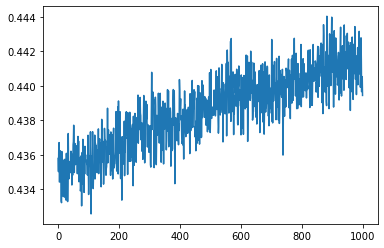

In [61]:
plt.plot(accs)

In [40]:
# train accuracy
models.accuracy(net,torch.tensor(ds_train.samples),torch.tensor(ds_train.labels))

514.0 520


0.9884615384615385

In [41]:
# test accuracy
models.accuracy(net,torch.tensor(ds_test.samples),torch.tensor(ds_test.labels))

53.0 130


0.4076923076923077

In [ ]:
predictions_train=[(torch.argmax(p,dim=-1)).item() for p in net(ds_train.samples)]

In [ ]:
# compute accuracy
sum([int(p==l) for p,l in zip(predictions_train,ds_train.labels)])/len(predictions_train)

In [ ]:
predictions_test=[(torch.argmax(p,dim=-1)).item() for p in net(ds_test.samples)]

In [ ]:
# compute accuracy
sum([int(p==l) for p,l in zip(predictions_test,ds_test.labels)])/len(predictions_test)

##### RIPPER Rule Learner (there is also IREP in the same package) this needs to be debugged first

In [ ]:
ds_train=MyDS(trainf.iloc[:,0:-4].values,trainf.iloc[:,-3].values,task='regression')
ds_test=MyDS(testf.iloc[:,0:-4].values,testf.iloc[:,-3].values,task='regression')

In [ ]:
# You will need to install this via pip install wittgenstien
import wittgenstein as lw

In [ ]:
ripper_clf = lw.RIPPER(max_rules=4,
        max_rule_conds=2,
        max_total_conds=6)

In [ ]:
# np.array([int(l*4) for l in ds_train.labels])

In [ ]:
ripper_clf.fit(ds_train.samples.numpy(),np.array([int(l*4) for l in ds_train.labels]),pos_class=1)

In [ ]:
ripper_clf.out_model()

In [ ]:
# make predictions
predictions_train=ripper_clf.predict(ds_train.samples.numpy())

In [ ]:
# predictions_train

In [ ]:
def class_accuracy(predictions,y,class_id):
    eq=[(lambda x: 1 if x[0]==x[1] else 0)(x) for x in zip(predictions,y==class_id)]
    return sum(eq)/len(eq)

In [ ]:
def class_pos_precision(predictions,y,class_id):
    eq=[(lambda x: 1 if (x[0]==x[1] and x[0]==True) else 0)(x) for x in zip(predictions,y==class_id)]
    return sum(eq)/len(eq)

In [ ]:
class_accuracy(predictions_train,np.array([int(l*4) for l in ds_train.labels]),1)

In [ ]:
class_pos_precision(predictions_train,np.array([int(l*4) for l in ds_train.labels]),1)

In [ ]:
# RIPPER needs debugging - using simpler dataset appears working but not here

##### Differentiable rule network - this will need to be extended as part two of the project

In [ ]:
from differentiable_rules import DiffRule

In [ ]:
dr= DiffRule(25,5,3,3)

In [ ]:
net,losses,accs=models.Train(dr,dsloader,epochs=100,verbose=True)

## Format for Table of Results (to be Created) 
Extend this as needed, i.e. different algorithms, different train-test file combinations

<table>
<thead>
<tr><th>Dataset</th><th>XgbR</th><th>XgbC</th><th>GBR</th></tr>
</thead>
<tbody>
<tr><td></td><td>params..<td>params..</td><td>params..</td></tr>
    <tr><td>file_train</td><td>RMSE</td><td>Acc</td><td>RMSE</td></tr>
    <tr><td>file_test</td><td>RMSE</td><td>Acc</td><td>RMSE</td></tr>
</tbody>
</table>